This code is a translation of the CMS Higgs to 4 leptons analysis from https://github.com/cms-opendata-analyses/HiggsExample20112012/blob/master/HiggsDemoAnalyzer/src/HiggsDemoAnalyzerGit.cc. 

It performs the analsysis on a NTuple of http://opendata.cern.ch/record/1507, produced using the EDAnalyzer of the following Outreach Tool, https://github.com/cms-opendata-analyses/AOD2NanoAODOutreachTool/blob/master/src/AOD2NanoAOD.cc. It then produces and saves the histograms for the Higgs to 4 muons, 4 electrons and 2muons2electrons decays.

In [1]:
### imports ###
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema

In [2]:
### constants ### 

# Z boson mass
mZ = 91.1876 # GeV

# histogram binning
bins = np.arange(70, 184, 3)

The following three cells each gets the 4-leptons-decay-mass branch from their respective TTree from the HiggsExample20112012 NTuples, which I named *giteda*, in the NanoAOD.

The python configuration file I ran included both the Outreach Tool and HiggsExample20112012 EDAnalyzers, so these cells may not run for you unless you do the same.

In [3]:
### original code histograms ###

## 4 muons starts ##
# 4muon TTree
original_4mu = NanoEventsFactory.from_root(
        "\\Users\\bocr9\\shared-folder\\2011MCNtuples.root",
        "giteda/tree4mu",
        schemaclass=NanoAODSchema
).events()

# Higgs -> 4 muons mass branch
original_Higgs_4mu = original_4mu.mass4mu

## 4 muons end ##

In [4]:
## 4 electrons starts ##

# 4electron TTree
original_4e = NanoEventsFactory.from_root(
        "\\Users\\bocr9\\shared-folder\\2011MCNtuples.root",
        "giteda/tree4e",
        schemaclass=NanoAODSchema
).events()

# Higgs -> 4 electrons mass branch
original_Higgs_4e = original_4e.mass4e

## 4 electrons ends ##

In [5]:
## 2 muons, 2 electrons starts ##

# 2mu2e TTree
original_2mu2e = NanoEventsFactory.from_root(
        "\\Users\\bocr9\\shared-folder\\2011MCNtuples.root",
        "giteda/tree2mu2e",
        schemaclass=NanoAODSchema
).events()

# Higgs -> 2mu2e mass branch
original_Higgs_2mu2e = original_2mu2e.mass2mu2e

## 2 muons, 2 electrons ends ##


### original code histogram ends ###

This cell gets the Events TTree from the Outreach Tool's NTuple, named *aod2nanoaod*, in the NanoAOD. Then, it selects the Muon and Electron branches from the Events, storing them on the variables *Muons* and *Electrons*, respectively.

In [6]:
### Outreach Tool code histograms starts ### 

## TTree selection
aod2naod = NanoEventsFactory.from_root(
        "\\Users\\bocr9\\shared-folder\\2011MCNtuples.root",
        "aod2nanoaod/Events",
        schemaclass=NanoAODSchema
).events()

## Branch selection
Muons = aod2naod.Muon

Electrons = aod2naod.Electron

This cell performs the first part of the Higgs decay to 4 leptons analysis. It slices to the *Muons* and *Electrons* variables based on the values their parameters must meet.

In [7]:
## good object selection

# good muons
good_mu = Muons[ (np.abs(np.sqrt(Muons.dxy**2+Muons.dz**2)/np.sqrt(Muons.dxyErr**2+Muons.dzErr**2))<4) &
                 (np.abs(Muons.dxy)<0.5) &
                 (np.abs(Muons.dz)<1) &
                 (np.abs(Muons.pfRelIso04_all)<0.4) &
                 (Muons.pt>5) &
                 (np.abs(Muons.eta)<2.4) ]

# good electrons
good_e = Electrons[ (Electrons.pt>7) & 
                    (np.abs(Electrons.eta)<2.5) &
                    (np.abs(np.sqrt(Electrons.dxy**2+Electrons.dz**2)/np.sqrt(Electrons.dxyErr**2+Electrons.dzErr**2))<4) &
                    (np.abs(Electrons.pfRelIso03_all)<0.4) & 
                    (np.abs(Electrons.dxy)<0.5) &
                    (np.abs(Electrons.dz)<1) ]

This cell contains a function which will be used for the Higgs to 4 muons and 4 electrons decays. It calculates the closest Z boson from the pairs of muons or electrons masses that have a net charge of zero, returning a boolean to apply as a cut to pairs of muons or electrons to find the good candidates of ZZ the Higgs decayed into, before decaying into the 4 leptons.

In [8]:
# function that finds the best combination of pairs with a mass closest to the real Z mass
def closest(pair):
    delta = abs(91.1876 - pair.mass[:])
    closest_masses = np.min(delta, axis=-1)
    the_closest = (delta == closest_masses)
    return the_closest 

This cells performs the rest of the analysis on the Higgs decay to 4 muons. In order, it...
* selects the entries of the good muons that contain 4 or more muons.
* sorts the entries of 4 muons from highest to lowest transverse momentum, pt.
* selects the first 4 muons from each element of the sorted array.
* selects the entries of the array whose 4 muons net charge is zero.
* makes unique pairs out of the 4 muons from every element of the *f4c0_mu4* array. 
* selects the unique pairs with a net charge of zero. 
* uses the *closest* function to find the closest Z boson from the muon pairs, *Za_muons*; flip *Za_muons* to get the farthest Z bosons from the muons pairs, *Zb_muons*.
* apply the boolean returned from the *closest* muon pairs, *Za_muons* and *Zb_muons*, to the *muon_pair_c0* array, to get the best muon pairs that decayed from these Z bosons.
* flatten these arrays to lose their awkward-array nature.
* get the mass cut for *Za_mu* and *Zb_mu*.
* get the pt cut for the *Za_mu* muons.
* apply the mass and pt cuts to *Za_mu* and *Zb_mu* to get the good Za and good Zb that decayed from the Higgs boson.
* perform a sum of the first two muons of every element from *good_Za_mu* and *good_Zb_mu* to get the Higgs boson.
* apply a mass cut to get the entries with a Higgs mass greater than 70 GeV.

In [9]:
### Higgs to 4 muons ###

# entries with 4 muons
mu4 = good_mu[ak.num(good_mu) >= 4]

# sort the events from highest to lowest transverse momentum
mu4_sorted = mu4[ak.argsort(mu4.pt, axis=-1, ascending=False)]

# select the first 4 muons from the sorted mu4
f4_mu4_sorted = mu4_sorted[:,0:4]

# select the 4 muons with a zero net charge
f4c0_mu4_sorted = f4_mu4_sorted[ak.sum(f4_mu4_sorted[:,:,"charge"], axis=-1) == 0]

# creating muon pairs
muon_pair = ak.combinations(f4c0_mu4_sorted, 2)

# combinations with zero net charge
muon_pair_c0 = muon_pair[(muon_pair["0"].charge + muon_pair["1"].charge)==0]

# get the closest Z boson (Za) and farthest Z boson (Zb)
Z_muons = (muon_pair_c0["0"] + muon_pair_c0["1"])
Za_muons = closest(Z_muons)
Zb_muons = Za_muons[:,::-1]

# best combination of muons
Za_2mu = muon_pair_c0[Za_muons]
Zb_2mu = muon_pair_c0[Zb_muons]

# flatten the arrays
Za_mu = ak.flatten(Za_2mu)
Zb_mu = ak.flatten(Zb_2mu)

# Mass requirement 
M_Za_mu = (((Za_mu["0"]+Za_mu["1"]).mass>40)&((Za_mu["0"]+Za_mu["1"]).mass<120))
M_Zb_mu = (((Zb_mu["0"]+Zb_mu["1"]).mass>12)&((Zb_mu["0"]+Zb_mu["1"]).mass<120))

# Transverse momentum requirement
pt_Z_mu = (Za_mu["0"].pt>20)&(Za_mu["1"].pt>10)

# applying the cuts to get the good Z bosons
good_Za_mu = Za_mu[pt_Z_mu&M_Za_mu&M_Zb_mu]
good_Zb_mu = Zb_mu[pt_Z_mu&M_Za_mu&M_Zb_mu]

# adding the Z boson pairs (Higgs decay to 4 muons calculation)
higgs4mu = good_Za_mu['0']+good_Za_mu['1'] + good_Zb_mu['0']+good_Zb_mu['1']

# applying a mass range
Higgs_4mu = higgs4mu[higgs4mu.mass>70]


### Higgs to 4 muons ends ###

This cells performs the rest of the analysis on the Higgs decay to 4 electrons. It's practically the same as the 4 muons decay. In order, it...
* selects the entries of the good electrons that contain 4 or more electrons.
* sorts the entries of 4 electrons from highest to lowest transverse momentum, pt.
* selects the first 4 electrons from each element of the sorted array.
* selects the entries of the array whose 4 electrons net charge is zero.
* makes unique pairs out of the 4 electrons from every element of the *f4c0_e4* array. 
* selects the unique pairs with a net charge of zero. 
* uses the *closest* function to find the closest Z boson from the electron pairs, *Za_electrons*; flip *Za_electrons* to get the farthest Z bosons from the muons pairs, *Zb_electrons*.
* apply the boolean returned from the *closest* electron pairs, *Za_electrons* and *Zb_electrons*, to the *e_pair_c0* array, to get the best electron pairs that decayed from these Z bosons.
* flatten these arrays to lose their awkward-array nature.
* get the mass cut for *Za_e* and *Zb_e*.
* get the pt cut for the *Za_e* electrons.
* apply the mass and pt cuts to *Za_e* and *Zb_e* to get the good Za and good Zb that decayed from the Higgs boson.
* perform a sum of the first two electrons of every element from *good_Za_e* and *good_Zb_e* to get the Higgs boson.
* apply a mass cut to get the entries with a Higgs mass greater than 70 GeV.

In [10]:
### Higgs to 4 electrons starts ###

# entries with four electrons
e4 = good_e[ ak.num(good_e)>=4 ]

# sorting the events from high to low transverse momentum
e4_sorted = e4[ak.argsort(e4.pt, axis=-1, ascending=False)]

# selecting the first 4 electrons from the sorted e4
f4_e4_sorted = e4_sorted[:,0:4]

# selecting the 4 electrons with a zero net charge
f4c0_e4_sorted = f4_e4_sorted[ ak.sum(f4_e4_sorted[:,:,"charge"], axis=-1)==0 ]

# creating electron pairs
e_pair = ak.combinations(f4c0_e4_sorted, 2)

# combinations with zero net charge
e_pair_c0 = e_pair[ (e_pair["0"].charge + e_pair["1"].charge)==0 ]

# get the closest Z boson (Za) and farthest Z boson (Zb)
Z_electrons = ( e_pair_c0["0"] + e_pair_c0["1"] )
Za_electrons = closest(Z_electrons)
Zb_electrons = Za_electrons[:,::-1]

# best combination of electrons
Za_2e = e_pair_c0[Za_electrons]
Zb_2e = e_pair_c0[Zb_electrons]

# flatten the arrays
Za_e = ak.flatten(Za_2e)
Zb_e = ak.flatten(Zb_2e)

# mass requirement
M_Za_e = (((Za_e["0"]+Za_e["1"]).mass>40)&((Za_e["0"]+Za_e["1"]).mass<120))
M_Zb_e = (((Zb_e["0"]+Zb_e["1"]).mass>12)&((Zb_e["0"]+Zb_e["1"]).mass<120))

# transverse momentum requirement
pt_Z_e = (Za_e["0"].pt>20)&(Za_e["1"].pt>10)

# applying the cuts to get the good Z bosons
good_Za_e = Za_e[pt_Z_e&M_Za_e&M_Zb_e]
good_Zb_e = Zb_e[pt_Z_e&M_Za_e&M_Zb_e]

# Adding the pair of Z bosons that decayed to 4 electrons
higgs4e = good_Za_e["0"]+good_Za_e["1"] + good_Zb_e["0"]+good_Zb_e["1"]

# applying a mass range
Higgs_4e = higgs4e[higgs4e.mass>70]


### Higgs to 4 electrons end ###

This cell performs the Higgs to 2 muons, 2 electrons decay analysis. It is rather similar to the 4 muons and 4 electrons decays; the main difference being that there is no need to consider unique pairs of muons and electrons. For this process, the Higgs decays into two Z bosons, where one decays into a pair of muons and the other into the pair of electrons.
In order...
* get the cut of events that contain entries of 2 or more good muons and good electrons.
* apply *two_and_two* cut to the good muons and good electrons.
* sort *good_mu* and *good_e* from highest to lowest transverse momentum, pt.
* select the first two muons and electrons from each element of the *twomuons_sorted* and *twoelect_sorted* arrays.
* get the charge cut for the events, that the net charge of the muon pairs and the net charge of the electron pairs is zero.
* get the Z boson that decayed into muons, *Z_mu*, and the one that decayd into electrons, *Z_e*. 
* obtain the difference between the *Z_mu* and *Z_e* masses from the real Z boson mass
* obtain a condition that test if the Z boson from the muon pairs is closer than the electron pairs. If the muons are closer, it performs a pt cut on the muons; if the electrons are closer, it performs the pt cut on the electrons.
* obtain the entries and the parameters for the closest Z boson, Za, testing where the muons are closer to the Z than the electrons.
* obtain the entries and the parameters for the farthest Z boson, Zb, testing where the electrons are closer to the Z than the muons.
* obtain the mass cut for Za and Zb.
* calculate the parameters for the Higgs boson using *Z_mu* and *Z_e*, and obtain the invariant mass of the Higgs.
* apply the *charge_cut* and the *mass_cut* to the Higgs' mass array, *H_M*.
* apply a mass cut to get the entries with a Higgs mass greater than 70 GeV.

In [11]:
### Higgs to 2 muons, 2 electrons starts ###

# two objects cut
two_and_two = (ak.num(good_mu)>=2) & (ak.num(good_e)>=2)

# entries with two objects
twomuons = good_mu[ two_and_two ]

twoelect = good_e[ two_and_two ]

# sort from highest to lowest transverse momentum
twomuons_sorted = twomuons[ak.argsort(twomuons.pt, axis=-1, ascending=False)]

twoelect_sorted = twoelect[ak.argsort(twoelect.pt, axis=-1, ascending=False)]

# first and second muons
mu1 = twomuons_sorted[:,0]
mu2 = twomuons_sorted[:,1]

# first and second electrons
e1 = twoelect_sorted[:,0]
e2 = twoelect_sorted[:,1]

## 
charge_cut = (mu1.charge + mu2.charge ==0) & (e1.charge + e2.charge ==0)
##

# Z boson from muon pairs
Z_mu = mu1+mu2

# Z boson from electron pairs
Z_e = e1+e2

# real Z boson and Z_mu mass difference
dZmu = abs(Z_mu.mass - mZ)

# real Z boson and Z_e mass difference
dZe = abs(Z_e.mass - mZ)

## condition to test which pair's mass is closer to the Z boson's mass
mu_is_closer = dZmu < dZe

ptZadaug = (mu_is_closer & ((mu1.pt > 20) & (mu2.pt > 10))) | (~mu_is_closer & ((e1.pt > 20) & (e2.pt > 10)))
##

# closest pair to the Z boson (Za)
eZa = np.where(mu_is_closer, Z_mu.energy, Z_e.energy)
pxZa = np.where(mu_is_closer, Z_mu.px, Z_e.px)
pyZa = np.where(mu_is_closer, Z_mu.py, Z_e.py)
pzZa = np.where(mu_is_closer, Z_mu.pz, Z_e.pz)
pTZa = np.where(mu_is_closer, Z_mu.pt, Z_e.pt)
mZa = np.where(mu_is_closer, Z_mu.mass, Z_e.mass)

# farthest pair to the Z boson (Zb)
eZb = np.where(mu_is_closer, Z_e.energy, Z_mu.energy)
pxZb = np.where(mu_is_closer, Z_e.px, Z_mu.px)
pyZb = np.where(mu_is_closer, Z_e.py, Z_mu.py)
pzZb = np.where(mu_is_closer, Z_e.pz, Z_mu.pz)
pTZb = np.where(mu_is_closer, Z_e.pt, Z_mu.pt)
mZb = np.where(mu_is_closer, Z_e.mass, Z_mu.mass)

## 
mass_cut = ( (ptZadaug) & ((mZa>40)&(mZa<120)) & ((mZb>12)&(mZb<120)) )
##

## calculating the Higgs from the sum of Za and Zb
# energy
H_en = Z_mu.energy + Z_e.energy

# momentum
H_px = Z_mu.px + Z_e.px
H_py = Z_mu.py + Z_e.py
H_pz = Z_mu.pz + Z_e.pz

# momentum's magnitude
H_P = np.sqrt(H_px**2 + H_py**2 + H_pz**2)

# invariant mass
H_M = np.sqrt(H_en**2 - H_P**2)

# applying the charge and mass cuts
higgs2mu2e = H_M[ charge_cut & mass_cut]

# applying a mass range
Higgs_2mu2e = higgs2mu2e[higgs2mu2e>70]

The following three cells will seperately plot the three Higgs to 4 leptons decays and saves them as a *png* in your local *Jypter Notebook* folder.

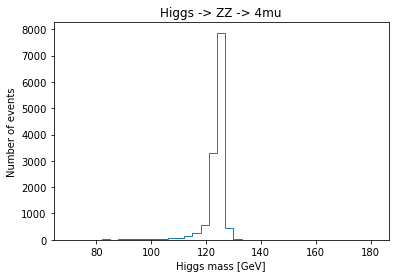

In [12]:
### Plots ###

## Higgs -> 4 mu
plt.hist(Higgs_4mu.mass, histtype='step', bins=bins)
plt.title(r'Higgs -> ZZ -> 4mu')
plt.xlabel('Higgs mass [GeV]')
plt.ylabel('Number of events')
plt.savefig('Higgs_4mu.png')

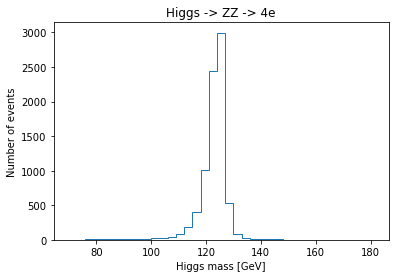

In [13]:
## Higgs -> 4e
plt.hist(Higgs_4e.mass, histtype='step', bins=bins)
plt.title(r'Higgs -> ZZ -> 4e')
plt.xlabel('Higgs mass [GeV]')
plt.ylabel('Number of events')
plt.savefig('Higgs_4e.png')

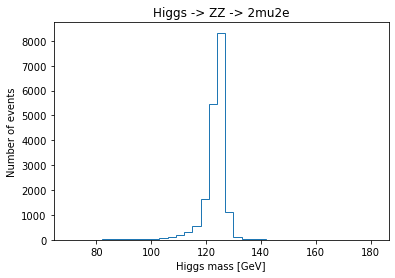

In [14]:
## Higgs -> 2mu2e
plt.hist(Higgs_2mu2e, histtype='step', bins=bins)
plt.title(r'Higgs -> ZZ -> 2mu2e')
plt.xlabel('Higgs mass [GeV]')
plt.ylabel('Number of events')
plt.savefig('Higgs_2mu2e.png')